<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/%EC%9E%A5%EA%B8%B0/%EB%AC%B8%EB%8B%A8_%EA%B2%80%EC%B6%9C%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 데이터 세트

In [1]:
%cd /content
!git clone https://github.com/ibm-aur-nlp/PubLayNet.git

/content
Cloning into 'PubLayNet'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 282 (delta 44), reused 44 (delta 44), pack-reused 236
Receiving objects: 100% (282/282), 40.14 MiB | 23.54 MiB/s, done.
Resolving deltas: 100% (127/127), done.


##### 예제 https://github.com/facebookresearch/detectron2.git
- https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=ZyAvNCJMmvFF

In [2]:
!pip install cython; pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-iydug1_4
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-iydug1_4
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=379038 sha256=23d561f8adc9cdb1796bc074ea8bc7b0bb713970f56f7520be8ef72d01b93d4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xyto5buv/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -e .

# or if you are on macOS
# MACOSX_DEPLOYMENT_TARGET=10.9 CC=clang CXX=clang++ pip install -e .

# or, as an alternative to `pip install`, use
# python setup.py build develop

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("/content/detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# (add --user if you don't have permission)

# Or, to install it from a local clone:
# !git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2

# On macOS, you may need to prepend the above commands with a few environment variables:
!CC=clang CXX=clang++ ARCHFLAGS="-arch x86_64" python -m pip install ...

In [17]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [18]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

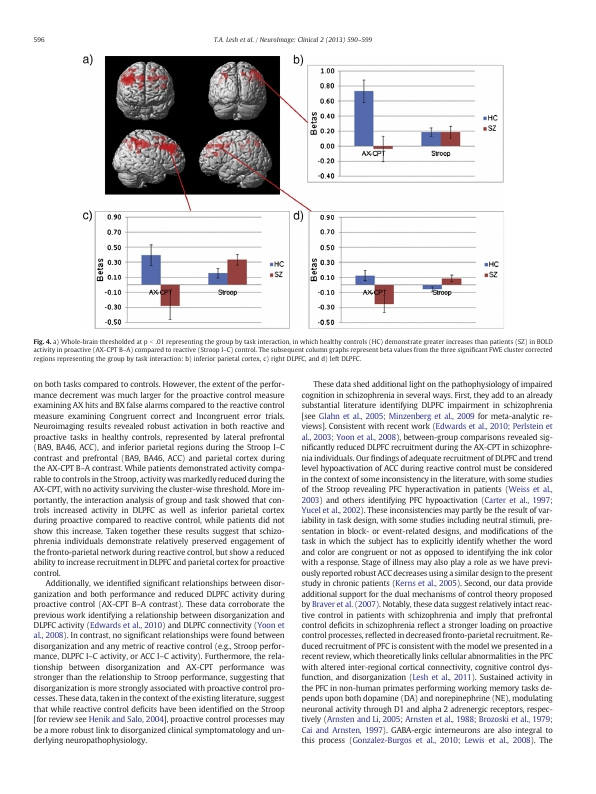

In [6]:
# !wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("/content/PubLayNet/examples/PMC3777717_00006.jpg")
cv2_imshow(im)

In [ ]:
cfg = get_cfg()
# detectorron2의 핵심 라이브러리에서 모델을 실행하지 않는 경우 여기에 프로젝트별 구성(예: TensorMask)을 추가합니다.
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# detector2의 모델 동물원에서 모델을 찾습니다. https://dl.fbaipublicfiles... URL도 사용할 수 있습니다.
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

##### https://github.com/hpanwar08/detectron2/blob/master/README.md

In [11]:
%cd /content

/content


In [12]:
!git clone https://github.com/hpanwar08/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 2152, done.
remote: Total 2152 (delta 0), reused 0 (delta 0), pack-reused 2152
Receiving objects: 100% (2152/2152), 4.64 MiB | 22.61 MiB/s, done.
Resolving deltas: 100% (1355/1355), done.


In [ ]:
# 모델 경로
model_id = "/content/drive/MyDrive/model_final_trimmed.pth"

In [27]:
!python /content/detectron2_1/demo/demo.py --config-file /content/detectron2_1/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml --input "/content/문학 교과서가 사랑한 작품500 현대산문_5.png" --output "/content" --confidence-threshold 0.5 --opts MODEL.WEIGHTS /content/drive/MyDrive/model_final_trimmed.pth MODEL.DEVICE cpu

[09/27 01:05:02 detectron2]: Arguments: Namespace(config_file='/content/detectron2_1/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml', webcam=False, video_input=None, input=['/content/문학 교과서가 사랑한 작품500 현대산문_5.png'], output='/content', confidence_threshold=0.5, opts=['MODEL.WEIGHTS', '/content/drive/MyDrive/model_final_trimmed.pth', 'MODEL.DEVICE', 'cpu'])
WARNING [09/27 01:05:02 d2.config.compat]: Config '/content/detectron2_1/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[09/27 01:05:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/model_final_trimmed.pth ...
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore

### 다른 모델